# HadCRUT5 ML Experiment

## Setup

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error

plt.style.use("fivethirtyeight")
plt.rcParams['lines.linewidth'] = 1
pd.set_option("display.float_format", "{:.2f}".format)
figsize = (15, 5)

## Load Data

Here we are just using 1 of the anomalie netcdf files for processing speed and space.

The dataset has dimensions of time, latitude and longitude. 
The dataset contains a data variable of "tas" representing monthly temperature anomalies using Kelvin as the unit. 

In [2]:
# Data used - the first file from the first zip in the HadCRUT5 analysis gridded data: ensemble members folder: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/download.html

dataset = xr.open_dataset("HadCRUT.5.0.2.0.analysis.anomalies.1.nc")
dataset

<xarray.Dataset>
Dimensions:         (time: 2095, latitude: 36, longitude: 72, bnds: 2)
Coordinates:
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 2024-07-16T...
  * latitude        (latitude) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude       (longitude) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
    realization     int64 ...
Dimensions without coordinates: bnds
Data variables:
    tas             (time, latitude, longitude) float64 ...
    time_bnds       (time, bnds) datetime64[ns] ...
    latitude_bnds   (latitude, bnds) float64 ...
    longitude_bnds  (longitude, bnds) float64 ...
Attributes:
    comment:      2m air temperature over land blended with sea water tempera...
    history:      Data set built at: 2024-09-02T14:38:01+00:00
    institution:  Met Office Hadley Centre / Climatic Research Unit, Universi...
    licence:      HadCRUT5 is licensed under the Open Government Licence v3.0...
    reference:    C. P. Morice, J. J. Kennedy, N. A. Rayner, J. P. Winn, E. H...
    source:       CRUTEM.5.0.2.0 HadSST.4.0.1.0
    title:        HadCRUT.5.0.2.0 blended land air temperature and sea-surfac...
    version:      HadCRUT.5.0.2.0
    Conventions:  CF-1.7

In [3]:
# Check the variable unit type. 
dataset.tas.units

'K'

In this Machine Learning demo we will explore Xarray's .to_dataframe() method which enables us to convert a multidimensional Xarray dataset to a Pandas Dataframe. If you are new to working with multidimensional data, this might provide an option to get started working with netcdf and other multidimensional dataset files. 

In [4]:
# Convert the Xarray dataset to a Pandas DataFrame.
df = dataset.to_dataframe()

In [5]:
df

tas  time_bnds  latitude_bnds  \
time                latitude longitude bnds                                  
1850-01-16 12:00:00 -87.50   -177.50   0     NaN 1850-01-01         -90.00   
                                       1     NaN 1850-02-01         -85.00   
                             -172.50   0     NaN 1850-01-01         -90.00   
                                       1     NaN 1850-02-01         -85.00   
                             -167.50   0     NaN 1850-01-01         -90.00   
...                                          ...        ...            ...   
2024-07-16 12:00:00 87.50    167.50    1    1.72 2024-08-01          90.00   
                             172.50    0    1.71 2024-07-01          85.00   
                                       1    1.71 2024-08-01          90.00   
                             177.50    0    1.70 2024-07-01          85.00   
                                       1    1.70 2024-08-01          90.00   

                                             longitude_bnds  realization  
time                latitude longitude bnds                               
1850-01-16 12:00:00 -87.50   -177.50   0            -180.00            1  
                                       1            -175.00            1  
                             -172.50   0            -175.00            1  
                                       1            -170.00            1  
                             -167.50   0            -170.00            1  
...                                                     ...          ...  
2024-07-16 12:00:00 87.50    167.50    1             170.00            1  
                             172.50    0             170.00            1  
                                       1             175.00            1  
                             177.50    0             175.00            1  
                                       1             180.00            1  

[10860480 rows x 5 columns]

As you can see above the DataFrame index is a matrix of dimensionality information, including time, latitude and longitude. Lets restructure out dataset.

In [6]:
# Reset the index to convert index levels to columns
df_reset = df.reset_index()

# Now filter the Dataframe to include only the desired columns
feature_columns = ["time", "latitude", "longitude", "tas"]
df = df_reset[feature_columns]
df

,time,latitude,longitude,tas
0,1850-01-16 12:00:00,-87.50,-177.50,NaN
1,1850-01-16 12:00:00,-87.50,-177.50,NaN
2,1850-01-16 12:00:00,-87.50,-172.50,NaN
3,1850-01-16 12:00:00,-87.50,-172.50,NaN
4,1850-01-16 12:00:00,-87.50,-167.50,NaN
...,...,...,...,...
10860475,2024-07-16 12:00:00,87.50,167.50,1.72
10860476,2024-07-16 12:00:00,87.50,172.50,1.71
10860477,2024-07-16 12:00:00,87.50,172.50,1.71
10860478,2024-07-16 12:00:00,87.50,177.50,1.70


## Null Values

In [7]:
# Lets review some of the key information about our dataset. 
df.describe()

,time,latitude,longitude,tas
count,10860480,10860480.00,10860480.00,8661168.00
mean,1937-04-16 17:49:51.694513792,0.00,0.00,0.04
min,1850-01-16 12:00:00,-87.50,-177.50,-16.74
25%,1893-08-16 12:00:00,-43.75,-88.75,-0.60
50%,1937-04-16 00:00:00,0.00,0.00,-0.00
75%,1980-12-16 12:00:00,43.75,88.75,0.62
max,2024-07-16 12:00:00,87.50,177.50,12.78
std,NaN,51.94,103.91,1.34


Lets review how many null values we have in our dataset. As you can see ~20% of the tas values are null and will need removing or filling. 

In [8]:
# Calculate % of null values
(df.isna().sum() / df.shape[0]) * 100

time         0.00
latitude     0.00
longitude    0.00
tas         20.25
dtype: float64

In [9]:
# Lets check out DataFrame shape to check how many values we have. 
df.shape

(10860480, 4)

As we have a high number of values lets just drop the null values. 

In [10]:
# Drop the null values from the dataset. 
df = df.dropna(subset=["tas"])

# Check the shape again. 
df.shape

(8661168, 4)

## Visualise Data

It might be beneficial to visualise the data to check for outliers, check the distribution and understand it better. 

<Axes: ylabel='Frequency'>

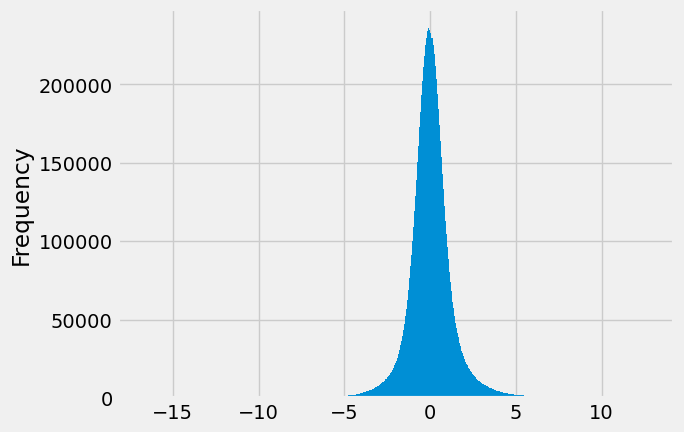

In [11]:
# Visualise the variable distribution. 
df["tas"].plot(kind="hist", bins=500)

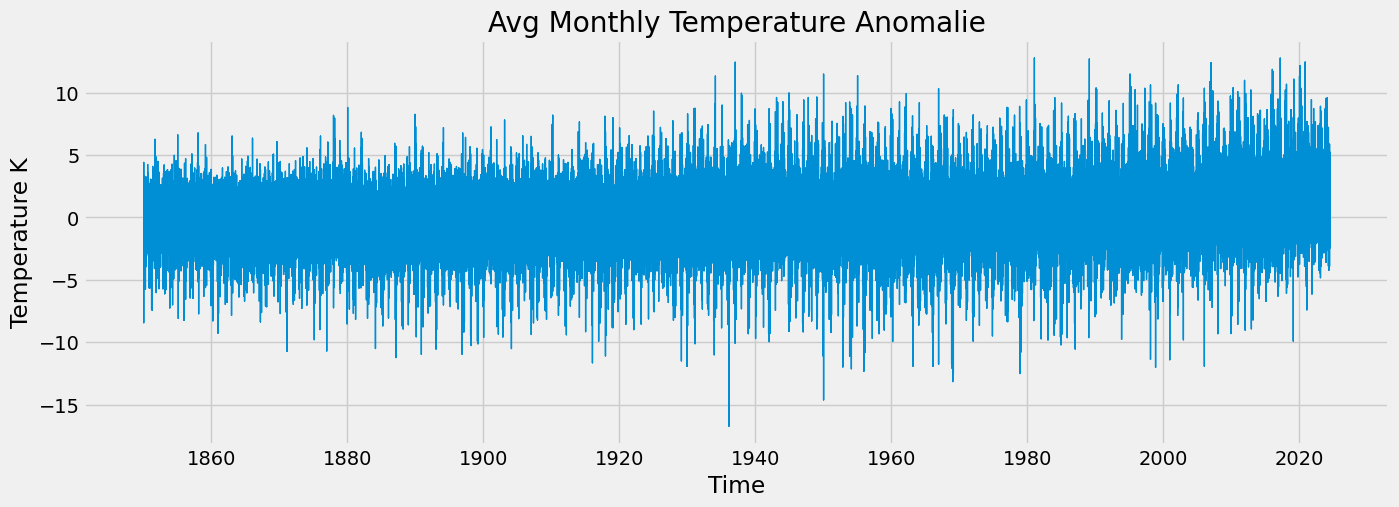

In [12]:
# Visualise the Dataset timeseries. 
plt.figure(figsize=figsize)
plt.plot(df["time"], df["tas"])
plt.title("Avg Monthly Temperature Anomalie")
plt.xlabel("Time")
plt.ylabel("Temperature K")
plt.show()

## Time Series

### Set the dataframe index to the time column

In [13]:
# Check time column is of datetime datatype
df.loc[:, "time"] = pd.to_datetime(df["time"])

In [14]:
# Sort dataframe by date
df = df.sort_values(by='time')

In [15]:
# Set the time column to the dataframe index
df = df.set_index("time")
df

,latitude,longitude,tas
time,,,
1850-01-16 12:00:00,-62.50,-112.50,-0.27
1850-01-16 12:00:00,37.50,-62.50,1.25
1850-01-16 12:00:00,37.50,-67.50,1.11
1850-01-16 12:00:00,37.50,-67.50,1.11
1850-01-16 12:00:00,37.50,-72.50,0.85
...,...,...,...
2024-07-16 12:00:00,-27.50,-77.50,-0.15
2024-07-16 12:00:00,-27.50,-82.50,0.47
2024-07-16 12:00:00,-27.50,-82.50,0.47


### Cut off point

We will reduce the size of the data by cutting off data pre 1950. This will help with the performance of this notebook for running on local machines. 

In [16]:
cutoff_date = "1950-01-01"  # Replace with your desired cutoff date
df = df[df.index >= cutoff_date]
df

,latitude,longitude,tas
time,,,
1950-01-16 12:00:00,37.50,7.50,0.17
1950-01-16 12:00:00,37.50,12.50,0.39
1950-01-16 12:00:00,37.50,2.50,-0.21
1950-01-16 12:00:00,37.50,-2.50,-0.27
1950-01-16 12:00:00,37.50,2.50,-0.21
...,...,...,...
2024-07-16 12:00:00,-27.50,-77.50,-0.15
2024-07-16 12:00:00,-27.50,-82.50,0.47
2024-07-16 12:00:00,-27.50,-82.50,0.47


### Train / Test split date

We will split our training data and our test data at a point in time. <br>
This means we will train on the data before this date and then test on the data on and after this date. 

In [17]:
# Choose a date to split on
date_to_split_on = "01-01-2004"

# Create a training DataFrame and assign it to the data before the split date. 
train = df.loc[df.index < date_to_split_on]

# Create a testing DataFrame and assign it to the data on and after the split date. 
test = df.loc[df.index >= date_to_split_on]

# Check the DataFrame shapes
train.shape, test.shape

((3227272, 3), (1270856, 3))

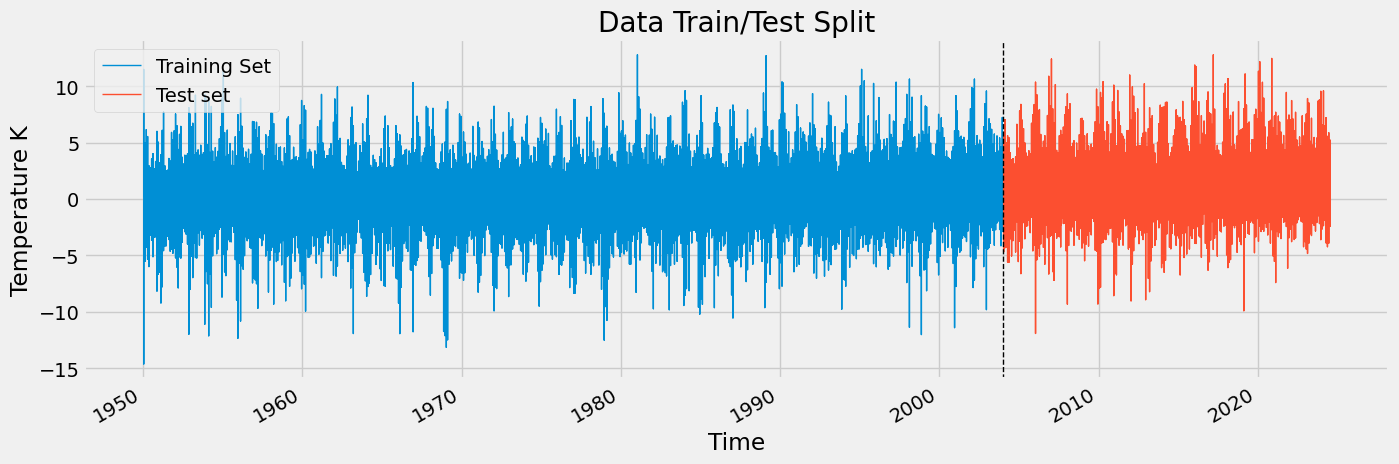

In [18]:
# Visualise the split data

fig, ax = plt.subplots(figsize=figsize)
train["tas"].plot(ax=ax, label="Training set", title = "Data Train/Test Split")
test["tas"].plot(ax=ax, label="Test set")
ax.axvline(date_to_split_on, color = "black", ls="--")
ax.legend(["Training Set", "Test set"], loc="upper left")
plt.xlabel("Time")
plt.ylabel("Temperature K")
plt.show()

### Time Series Cross Validation

TimeSeriesSplit is a cross-validation technique specifically designed for time series data. It ensures that the training and test sets are sequential, which is crucial for time series data where the order of observations matters such as this. Here is an example of how you could use this. 

In [19]:
# Import sklearn's TimeSeriesSplit funcitonality to facilitate this process. 
from sklearn.model_selection import TimeSeriesSplit

In [20]:
# Initialize TimeSeriesSplit with 4 splits, a test size of 100 years (assuming hourly data), and a gap of 24 hours
tss = TimeSeriesSplit(n_splits=4, test_size= 24*365*100, gap=24)

# Check the DataFrame is sorted by date index to ensure the time series order is correct
df = df.sort_index()

# Display the TimeSeriesSplit object to confirm its configuration
tss

TimeSeriesSplit(gap=24, max_train_size=None, n_splits=4, test_size=876000)

#### Visualise the Time Series Split

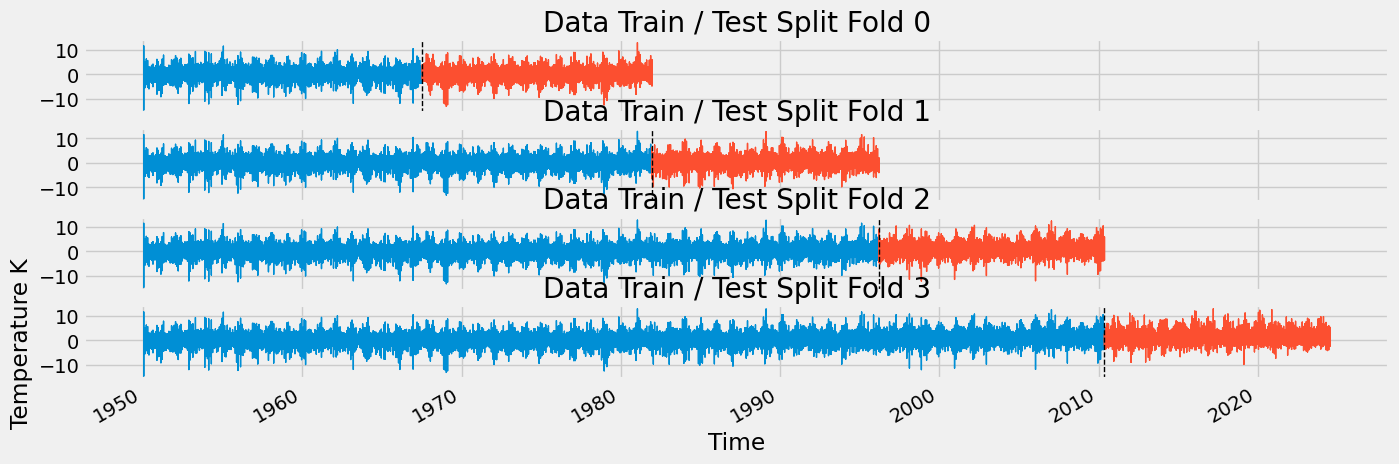

In [21]:
# Visualise what the Time Series Split does. 

# Create a figure with 4 subplots arranged vertically, sharing the x-axis
fig, axs = plt.subplots(4, 1, figsize = figsize, sharex=True)


# Initialize the fold counter
fold = 0

# Iterate over each train/test split generated by TimeSeriesSplit
for train_index, val_index in tss.split(df):
    
    train = df.iloc[train_index]    # Select training data based on the current split indices
    test = df.iloc[val_index]       # Select test data based on the current split indices
    
    # Plot the training data for the current fold
    train["tas"].plot(ax=axs[fold],
                     label="Training Set",
                     title=f"Data Train / Test Split Fold {fold}")
    test["tas"].plot(ax=axs[fold], label="Test Set")
    axs[fold].axvline(test.index.min(), color="black", ls="--")
    fold += 1

plt.xlabel("Time")
plt.ylabel("Temperature K")
plt.show()


## Feature Creation

We could try and create more data for our model by providing date time information such as the month, quarter and year information and see if this is relevant. 

In [22]:
def create_features(df):
    """
    Create time series features based on time series index
    
    Parameters: 
    Pandas DataFrame where the index is a timeseries
    
    Return: 
    Pandas DataFrame with month, quarter and year features. 
    """
    df = df.copy()
    df.loc[:,"month"] = df.index.month
    df.loc[:,"quarter"] = df.index.quarter
    df.loc[:,"year"] = df.index.year
    
    return df

df = create_features(df)
df.shape

(4498128, 6)

In [23]:
def add_lag_features(df):
    """
    Adds lag features to the DataFrame for time series analysis.

    This function creates lagged versions of the 'tas' column in the DataFrame.
    Each lagged column represents the 'tas' value shifted by a multiple of 364 days.

    Parameters:
    Pandas DataFrame containing a 'tas' column.

    Returns:
    Pandas DataFrame with added lag features.
    """
    
    lag = 364

    for i in range(1, 11):
        df[f"lag{i}"] = df["tas"].shift(lag * i)
    
    return df

In [24]:
df = add_lag_features(df)
df

,latitude,longitude,tas,month,quarter,year,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10
time,,,,,,,,,,,,,,,,
1950-01-16 12:00:00,37.50,7.50,0.17,1,1,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-16 12:00:00,37.50,12.50,0.39,1,1,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-16 12:00:00,37.50,2.50,-0.21,1,1,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-16 12:00:00,37.50,-2.50,-0.27,1,1,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-16 12:00:00,37.50,2.50,-0.21,1,1,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-16 12:00:00,-27.50,-77.50,-0.15,7,3,2024,1.48,0.11,0.66,3.12,3.49,-0.53,-0.23,4.44,2.02,0.03
2024-07-16 12:00:00,-27.50,-82.50,0.47,7,3,2024,1.67,0.27,0.51,-0.15,3.49,-0.53,-0.23,4.63,0.36,0.03
2024-07-16 12:00:00,-27.50,-82.50,0.47,7,3,2024,1.67,0.56,0.51,-0.26,3.69,-0.58,-0.09,4.63,0.40,0.25


#### Check null values.

As you can see from the Dataframe above we have added lag features for most of the DataFrame. However the initial rows have NaN values for these columns. This is becuase there is no prior data to construct the lag values from. <br>

As before, we must remove null values such as these from our data.

In [25]:
df = df.dropna()
df.shape

(4494488, 16)

#### Update the train / test DataFrames

In [26]:
# We need to update the train / test DataFrames we created earlier following our new features 

train = df.loc[df.index < date_to_split_on]
test = df.loc[df.index >= date_to_split_on]

train.shape, test.shape

((3223632, 16), (1270856, 16))

## Train using Cross Validation Example

In [27]:
df.columns

Index(['latitude', 'longitude', 'tas', 'month', 'quarter', 'year', 'lag1',
       'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9',
       'lag10'],
      dtype='object')

In [28]:
# Create a list of Features and a variable to store the target. 
FEATURES = ["latitude", "longitude", "lag1" , "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "lag8", "lag9", "lag10", "month"]
TARGET = "tas"

# Create an X_test DataFrame storing our feature columns using the test data (data from before the time split)
X_test = test[FEATURES]

# Create a y_test DataFrame storing our target variable column using the test data (data from before the time split)
y_test = test[TARGET]

In [29]:
# Sort the DataFrame by its index to ensure the time series data is in chronological order. 
df = df.sort_index()

fold = 0       # Initialize a counter to track the number of folds.
preds = []     # Create an empty list to store predictions from each fold.
scores = []    # Create an empty list to store the RMSE scores from each fold.


# # Loop over the splits generated by TimeSeriesSplit.
# for train_index, val_index in tss.split(df):
#     print(f"Training fold number: {fold}")
#     train = df.iloc[train_index]      # Select the training data based on the current split indices.
#     test = df.iloc[val_index]         # Select the validation data based on the current split indices.

#     train = create_features(train)    # Apply feature engineering to the training data.
#     test = create_features(test)      # Apply feature engineering to the validation data.
    
#     X_train = train[FEATURES]  # Extract the feature columns from the training data (pre date split).
#     y_train = train[TARGET]    # Extract the target column from the training data (pre date split).

#     X_test = test[FEATURES]  # Extract the feature columns from the validation data (post date split).
#     y_test = test[TARGET]    # Extract the target column from the validation data (post date split).

    
#     # Initialize the XGBoost regressor with specified hyperparameters.
#     reg = xgb.XGBRegressor(base_score=0.5, 
#                            booster="gbtree", 
#                            n_estimators=1000, 
#                            early_stopping_rounds=50, 
#                            objective="reg:squarederror", 
#                            max_depth=3, 
#                            learning_rate=0.01)

#     # Train the model on the training data.
#     reg.fit(X_train, y_train,
#            eval_set=[(X_train, y_train), (X_test, y_test)],
#            verbose=100)

#     # Make predictions on the validation data.
#     y_pred = reg.predict(X_test)
    
#     # Append the predictions to the list.
#     preds.append(y_pred)   
    
#     # Calculate the RMSE for the current fold.
#     score = np.sqrt(mean_squared_error(y_test, y_pred)) 
    
#     # Append the RMSE score to the list.
#     scores.append(score)    

#     # Increment the fold counter
#     fold += 1


In [30]:
# Print the average mean score for all folds and the individual score for each fold. 

print(f"Average score across folds {np.mean(scores): 0.4f}")
print(f"Fold scores: {scores}")

Average score across folds  nan
Fold scores: []


/opt/anaconda3/envs/HadCRUT5/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/HadCRUT5/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Train, Predict and Evalute Model

In [31]:
# Check the DataFrame contents.
df

,latitude,longitude,tas,month,quarter,year,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10
time,,,,,,,,,,,,,,,,
1950-01-16 12:00:00,-2.50,-92.50,-0.90,1,1,1950,-0.10,-0.16,-0.43,-5.28,-6.79,2.69,-0.62,-0.41,-0.55,0.17
1950-01-16 12:00:00,-2.50,-157.50,-0.33,1,1,1950,-0.10,-0.16,-0.20,-5.28,-6.79,2.71,-0.50,-0.24,-0.55,0.39
1950-01-16 12:00:00,-2.50,-97.50,-1.15,1,1,1950,0.12,-0.20,-0.40,-6.19,-6.51,2.71,-0.50,-0.24,-0.37,-0.21
1950-01-16 12:00:00,-2.50,-102.50,-1.85,1,1,1950,0.12,-0.20,0.83,-8.26,-7.14,2.65,-0.38,-0.33,-0.37,-0.27
1950-01-16 12:00:00,-2.50,-102.50,-1.85,1,1,1950,0.25,-0.07,0.20,-6.19,-4.08,2.72,0.15,0.56,0.55,-0.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-16 12:00:00,-27.50,-77.50,-0.15,7,3,2024,1.48,0.11,0.66,3.12,3.49,-0.53,-0.23,4.44,2.02,0.03
2024-07-16 12:00:00,-27.50,-82.50,0.47,7,3,2024,1.67,0.27,0.51,-0.15,3.49,-0.53,-0.23,4.63,0.36,0.03
2024-07-16 12:00:00,-27.50,-82.50,0.47,7,3,2024,1.67,0.56,0.51,-0.26,3.69,-0.58,-0.09,4.63,0.40,0.25


In [51]:
train = df.loc[df.index < date_to_split_on]
test = df.loc[df.index >= date_to_split_on]

train.shape, test.shape

((3223632, 16), (1270856, 16))

In [65]:
FEATURES = ["latitude", "longitude", "month", "quarter", "year", "lag1" , "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "lag8", "lag9", "lag10"]
TARGET = "tas"

# Split the data
X_train = train.drop("tas", axis="columns")
y_train = train["tas"]
X_test = test.drop("tas", axis="columns")
y_test = test["tas"]


In [66]:
X_train

,latitude,longitude,month,quarter,year,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10
time,,,,,,,,,,,,,,,
1950-01-16 12:00:00,-2.50,-92.50,1,1,1950,-0.10,-0.16,-0.43,-5.28,-6.79,2.69,-0.62,-0.41,-0.55,0.17
1950-01-16 12:00:00,-2.50,-157.50,1,1,1950,-0.10,-0.16,-0.20,-5.28,-6.79,2.71,-0.50,-0.24,-0.55,0.39
1950-01-16 12:00:00,-2.50,-97.50,1,1,1950,0.12,-0.20,-0.40,-6.19,-6.51,2.71,-0.50,-0.24,-0.37,-0.21
1950-01-16 12:00:00,-2.50,-102.50,1,1,1950,0.12,-0.20,0.83,-8.26,-7.14,2.65,-0.38,-0.33,-0.37,-0.27
1950-01-16 12:00:00,-2.50,-102.50,1,1,1950,0.25,-0.07,0.20,-6.19,-4.08,2.72,0.15,0.56,0.55,-0.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003-12-16 12:00:00,-32.50,172.50,12,4,2003,0.39,0.45,-0.27,0.18,2.94,0.59,0.51,5.05,-2.33,1.52
2003-12-16 12:00:00,-32.50,172.50,12,4,2003,-0.20,0.45,0.42,-0.95,1.91,0.25,0.40,5.12,-1.73,0.35
2003-12-16 12:00:00,-32.50,167.50,12,4,2003,0.12,0.62,-0.73,1.18,1.91,0.59,0.40,6.92,-1.47,0.35


In [67]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler_X = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = pd.DataFrame(scaler_X.fit_transform(X_train), columns=FEATURES)
X_test_scaled = pd.DataFrame(scaler_X.transform(X_test), columns=FEATURES)

# Check the shapes of the scaled data
X_train_scaled.shape, y_train.shape, X_test_scaled.shape, y_test.shape

((3223632, 15), (3223632,), (1270856, 15), (1270856,))

In [68]:
X_train_scaled

,latitude,longitude,month,quarter,year,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10
0,-0.10,-0.91,-1.58,-1.33,-1.76,-0.16,-0.20,-0.41,-4.14,-5.29,1.98,-0.56,-0.40,-0.50,0.05
1,-0.10,-1.53,-1.58,-1.33,-1.76,-0.16,-0.20,-0.24,-4.14,-5.29,2.00,-0.47,-0.27,-0.50,0.22
2,-0.10,-0.95,-1.58,-1.33,-1.76,0.01,-0.24,-0.39,-4.84,-5.08,2.00,-0.47,-0.27,-0.37,-0.24
3,-0.10,-1.00,-1.58,-1.33,-1.76,0.01,-0.24,0.55,-6.43,-5.57,1.96,-0.37,-0.34,-0.37,-0.29
4,-0.10,-1.00,-1.58,-1.33,-1.76,0.11,-0.14,0.07,-4.84,-3.22,2.01,0.03,0.35,0.34,-0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3223627,-0.69,1.65,1.59,1.34,1.68,0.22,0.26,-0.29,0.06,2.17,0.37,0.31,3.79,-1.87,1.09
3223628,-0.69,1.65,1.59,1.34,1.68,-0.24,0.26,0.24,-0.81,1.39,0.11,0.23,3.85,-1.41,0.19
3223629,-0.69,1.60,1.59,1.34,1.68,0.01,0.40,-0.64,0.83,1.39,0.37,0.23,5.23,-1.21,0.19
3223630,-0.69,1.60,1.59,1.34,1.68,-0.12,0.19,-0.64,0.10,1.41,0.20,-0.07,4.85,-1.21,-0.08


In [187]:
reg = xgb.XGBRegressor(base_score=0.5,
                      booster = "gbtree",
                      n_estimators=1500,
                      early_stopping_rounds=50, 
                      objective="reg:squarederror",
                      max_depth=5,
                      learning_rate=0.01)

reg.fit(X_train_scaled, y_train,
        eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
        verbose=100)

[0]	validation_0-rmse:1.35730	validation_1-rmse:1.52126
[100]	validation_0-rmse:1.26266	validation_1-rmse:1.41586
[200]	validation_0-rmse:1.24034	validation_1-rmse:1.36765
[300]	validation_0-rmse:1.23057	validation_1-rmse:1.34213
[400]	validation_0-rmse:1.22264	validation_1-rmse:1.33400
[500]	validation_0-rmse:1.21793	validation_1-rmse:1.32951
[600]	validation_0-rmse:1.21459	validation_1-rmse:1.32703
[700]	validation_0-rmse:1.21222	validation_1-rmse:1.32466
[800]	validation_0-rmse:1.20977	validation_1-rmse:1.32406
[900]	validation_0-rmse:1.20734	validation_1-rmse:1.32247
[964]	validation_0-rmse:1.20569	validation_1-rmse:1.32281


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

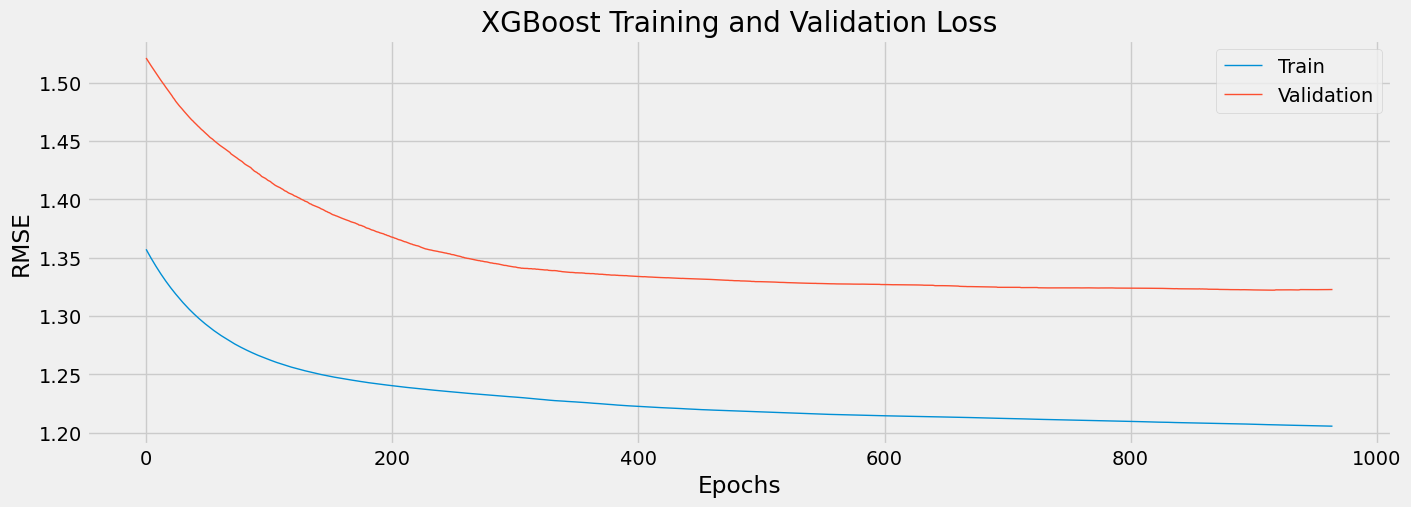

In [188]:
# Plot the loss curves

def loss_curve_graph(reg):

    results = reg.evals_result()
    epochs = len(results["validation_0"]["rmse"])
    x_axis = range(0, epochs)
    
    plt.figure(figsize=figsize)
    plt.plot(x_axis, results["validation_0"]["rmse"], label="Train")
    plt.plot(x_axis, results["validation_1"]["rmse"], label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("RMSE")
    plt.title("XGBoost Training and Validation Loss")
    plt.legend()
    plt.show()

loss_curve_graph(reg)

In [ ]:
# Create a future dataframe


### Feature Importance

Feature importance is a metric used to understand the impact of each feature (or variable) in a predictive model. In the context of machine learning, particularly with models like XGBoost, feature importance helps identify which features contribute the most to the model’s predictions. As we would anticipate lag1 has a higher impact than later lag years. 

In [ ]:
# Create a DataFrame to store the feature importances from the XGBoost model
feature_importance = pd.DataFrame(data=reg.feature_importances_,
                                 index=reg.feature_names_in_,
                                 columns=["importance"])

# Sort and plot the importances using a horizontal bar chart. 
feature_importance.sort_values("importance").plot(kind="barh", title="Feature Importance")
plt.show()

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [129]:
df.columns

Index(['latitude', 'longitude', 'tas', 'month', 'quarter', 'year', 'lag1',
       'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9',
       'lag10'],
      dtype='object')

In [106]:
df.shape

(4494488, 16)

In [107]:
train = create_features(train)
test = create_features(test)

FEATURES = ["latitude", "longitude", "tas"]
TARGET = "tas"

In [42]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [43]:
import os
import joblib

In [44]:
# Check if the model exists (its already been trained) and if it exists load the model. If not, create, train and save the model.

file_name = "HadCRUT5_XGB_model.pkl"

if os.path.exists(file_name):
    # Load the model from the file
    reg = joblib.load(file_name)
    print("Model loaded")
else:
    # Create Model
    reg = xgb.XGBRegressor(base_score=0.5,
                           n_estimators=1000, 
                           early_stopping_rounds=50, 
                           objective="reg:squarederror",
                           learning_rate=0.0075)
    
    # Train Model
    reg.fit(X_train, y_train,
           eval_set=[(X_train, y_train), (X_test, y_test)],
           verbose=100)
    
    # Save the model to a file
    joblib.dump(reg, file_name)

Model loaded


## Predictions

In [90]:
X_test.columns, X_train.columns, X_train_scaled.columns, X_test_scaled.columns

(Index(['latitude', 'longitude', 'month', 'quarter', 'year', 'lag1', 'lag2',
        'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10'],
       dtype='object'),
 Index(['latitude', 'longitude', 'month', 'quarter', 'year', 'lag1', 'lag2',
        'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10'],
       dtype='object'),
 Index(['latitude', 'longitude', 'month', 'quarter', 'year', 'lag1', 'lag2',
        'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10'],
       dtype='object'),
 Index(['latitude', 'longitude', 'month', 'quarter', 'year', 'lag1', 'lag2',
        'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10'],
       dtype='object'))

In [193]:
# Use the trained regression model to make predictions on the test data

#prediction = reg.predict(X_test)
prediction = reg.predict(X_test_scaled)


# Create a test DataFrame and add the predictions as a new column named 'prediction'
test.loc[: , "prediction"] = prediction

test.head()

prediction.shape, test.shape

((1270856,), (1270856, 17))

## Visualise Results

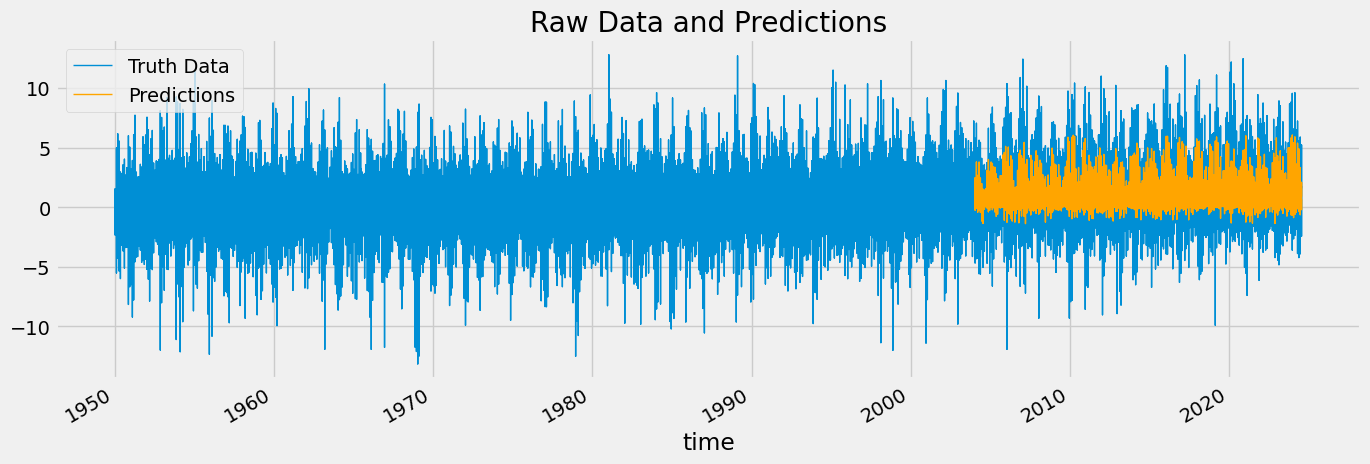

In [194]:
# Plot the 'tas' column from the original DataFrame.
ax = df["tas"].plot(figsize=figsize, label="Truth Data")

# Plot the 'prediction' column from the test DataFrame
test["prediction"].plot(ax=ax, label="Predictions", color='orange')

# Add legend and title
plt.legend(loc="upper left")
ax.set_title("Raw Data and Predictions")

# Show the plot
plt.show()

#### Focus on the overlapping time period. 

In [195]:
# Define the starting date for filtering the data
date_to_plot_from = "01-01-2010"

# Filter the DataFrame 'df' to include only rows with an index greater than or equal to the starting date
df_filtered = df[df.index >= date_to_plot_from]

# Similarly, filter the 'test' DataFrame to include only rows with an index greater than or equal to the starting date
test_filtered = test[test.index >= date_to_plot_from]

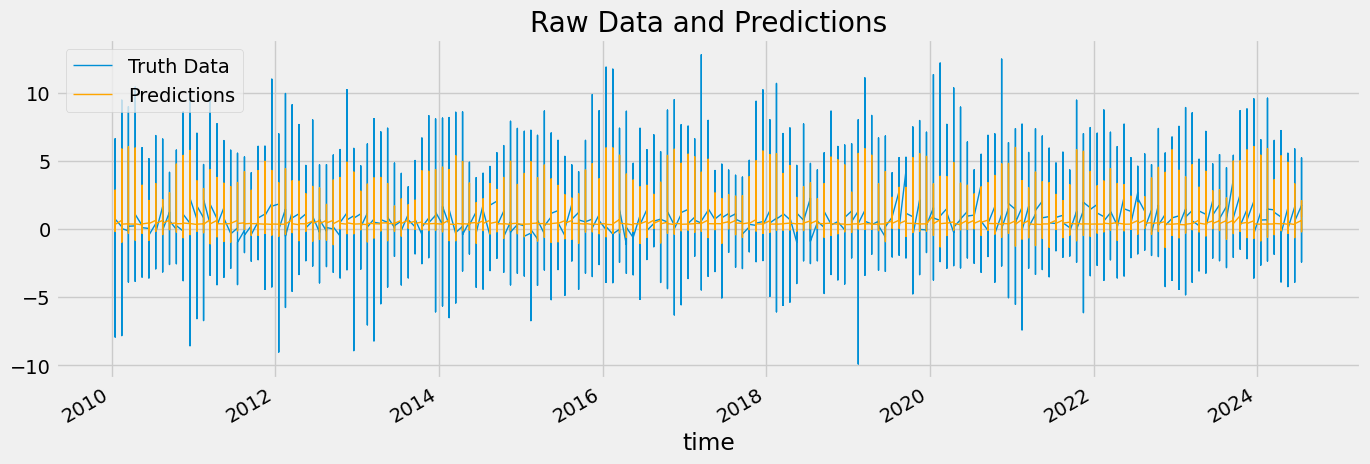

In [196]:
# Plot the 'tas' column from the filtered df
ax = df_filtered["tas"].plot(figsize=figsize, label="Truth Data")

# Plot the 'prediction' column from the filtered test
test_filtered["prediction"].plot(ax=ax, label="Predictions", color='orange')

# Add legend and title
plt.legend(loc="upper left")
ax.set_title("Raw Data and Predictions")

# Show the plot
plt.show()

## Next Steps

The graph above demonstrates that we are able to predict a similar anomalie shape for this period, but we are struggling to represent the extreme values. Consider how you could modify this project to improve the result. 

* **Feature Engineering:**
    * Create new features that might capture the behavior of extreme values better. For example, you could add interaction terms or polynomial features.
    * Transform existing features using techniques like log transformation, square root transformation, or binning to reduce the impact of extreme values.

* **Hyperparameter Tuning:**
    * Adjust the learning rate: A lower learning rate can help the model learn more slowly and potentially capture extreme values better.
    * Increase the number of trees: More trees can help the model capture more complex patterns.
    * Tune the max depth and min child weight: These parameters control the complexity of the model and can help in capturing extreme values.
    * Handling Outliers.

* **Ensemble Methods:**
    * Combine multiple models: Use techniques like stacking or blending to combine the predictions of multiple models. This can help in capturing extreme values better.
    * Use different algorithms: Combine XGBoost with other algorithms like Random Forests or Neural Networks to improve performance on extreme values.

* **Regularization:**
    * Adjust regularization parameters: XGBoost has parameters like alpha (L1 regularization) and lambda (L2 regularization) that can be tuned to improve model performance.
    * Resampling Techniques:
    * Oversample or undersample: If extreme values are rare, you can oversample these cases or undersample the more common cases to balance the dataset.
    * Synthetic data generation: Use techniques like SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic examples of extreme values.

* **Advanced Techniques:**
    * Gradient Boosting with Quantile Loss: Instead of using the default loss function, you can use quantile loss to better capture extreme values.
    * Anomaly Detection: Use anomaly detection techniques to identify and treat extreme values separately.

* **Cross-Validation:**
    * Use cross-validation to ensure that your model is not overfitting and is generalizing well to unseen data, including extreme values.